# **Modeling the Impact of Wheather on Water Consumption in Barcelona** 

## Model - Iteration 2

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load dataset
data_path = '../data'

df = pd.read_csv(os.path.join(data_path, 'consumption_weather.csv'), parse_dates=['FECHA'])
print(df.shape)
df.head()

(1458, 17)


,FECHA,CONSUM_DIARI,WindDir_Mean_10m,WindDir_Max_10m,Humidity_Mean,Humidity_Min,Humidity_Max,Pressure_Mean,Pressure_Min,Precipitation,Pressure_Max,Solar_Radiation_24h,Temp_Mean,Temp_Min,Temp_Max,WindSpeed_Mean_10m,WindSpeed_Max_10m
0,2021-01-01,2882779,331.67,321.67,67.50,57.25,78.00,984.23,982.87,0.43,985.73,1.67,7.65,5.52,9.10,3.30,11.77
1,2021-01-02,3123617,324.33,316.00,61.25,46.75,72.75,985.00,983.40,0.00,987.57,7.00,5.90,2.85,9.40,4.10,11.13
2,2021-01-03,3179900,302.67,316.67,49.25,33.25,69.25,988.83,987.20,0.00,990.27,8.57,5.32,2.58,9.80,3.30,11.27
3,2021-01-04,3384061,309.33,301.00,59.25,36.75,75.25,988.17,985.90,0.00,989.67,8.90,5.60,2.28,10.30,2.47,9.90
4,2021-01-05,3390447,299.33,322.00,65.00,46.75,78.50,989.37,987.67,0.00,991.10,7.10,4.95,2.08,9.35,2.53,7.83


In [3]:
# Feature Engineering

df['month'] = df['FECHA'].dt.month
df['dayofweek'] = df['FECHA'].dt.dayofweek
df['year'] = df['FECHA'].dt.year
df['CONSUMO_LAG1'] = df['CONSUM_DIARI'].shift(1)
df['CONSUMO_ROLL7'] = df['CONSUM_DIARI'].rolling(window=7).mean()
df['is_weekend'] = df['dayofweek'] >= 5
df = df.dropna()

df.head()

,FECHA,CONSUM_DIARI,WindDir_Mean_10m,WindDir_Max_10m,Humidity_Mean,Humidity_Min,Humidity_Max,Pressure_Mean,Pressure_Min,Precipitation,...,Temp_Min,Temp_Max,WindSpeed_Mean_10m,WindSpeed_Max_10m,month,dayofweek,year,CONSUMO_LAG1,CONSUMO_ROLL7,is_weekend
6,2021-01-07,3435585,33.00,247.00,70.00,56.75,90.50,992.73,990.73,0.73,...,3.72,6.95,2.40,7.53,1,3,2021,3141848.0,3.219748e+06,False
7,2021-01-08,3455260,125.00,36.33,59.25,38.25,77.25,991.63,988.53,0.00,...,1.48,7.30,2.20,10.23,1,4,2021,3435585.0,3.301531e+06,False
8,2021-01-09,3134726,50.00,45.33,77.75,45.00,94.75,985.70,983.17,19.53,...,3.28,7.00,6.87,18.53,1,5,2021,3455260.0,3.303118e+06,True
9,2021-01-10,3299294,133.67,37.00,75.25,60.75,90.50,990.07,984.53,5.03,...,4.65,7.60,4.27,16.50,1,6,2021,3134726.0,3.320174e+06,True
10,2021-01-11,3630946,312.67,308.33,69.50,56.00,82.25,998.30,995.13,0.00,...,1.82,8.22,4.43,11.60,1,0,2021,3299294.0,3.355444e+06,False


In [4]:
# Feature definition

target = 'CONSUM_DIARI'
features = [col for col in df.columns if col not in ["FECHA", target]]

# Train-test split

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (1161, 21), Test set: (291, 21)


MAE: 189321.14, RMSE: 315581.20, R²: 0.061


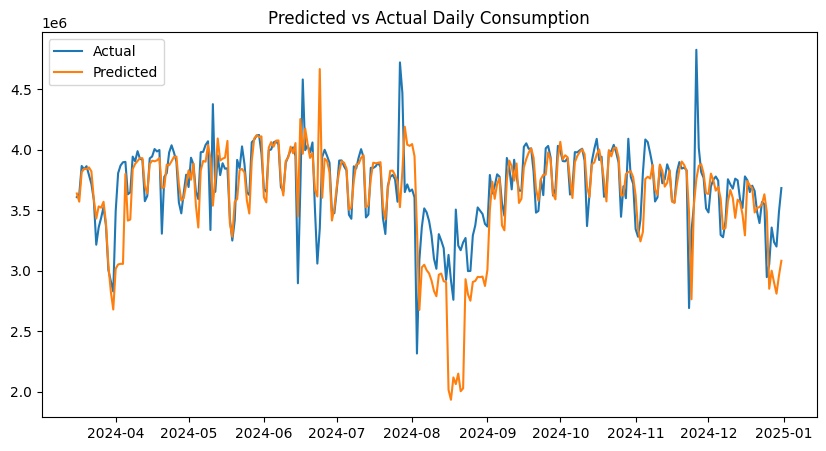

In [5]:
# Scale + model
model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))
])

# Train model
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")

# Plot results
plt.figure(figsize=(10,5))
plt.plot(df["FECHA"].iloc[-len(y_test):], y_test, label="Actual")
plt.plot(df["FECHA"].iloc[-len(y_test):], y_pred, label="Predicted")
plt.legend()
plt.title("Predicted vs Actual Daily Consumption")
plt.show()

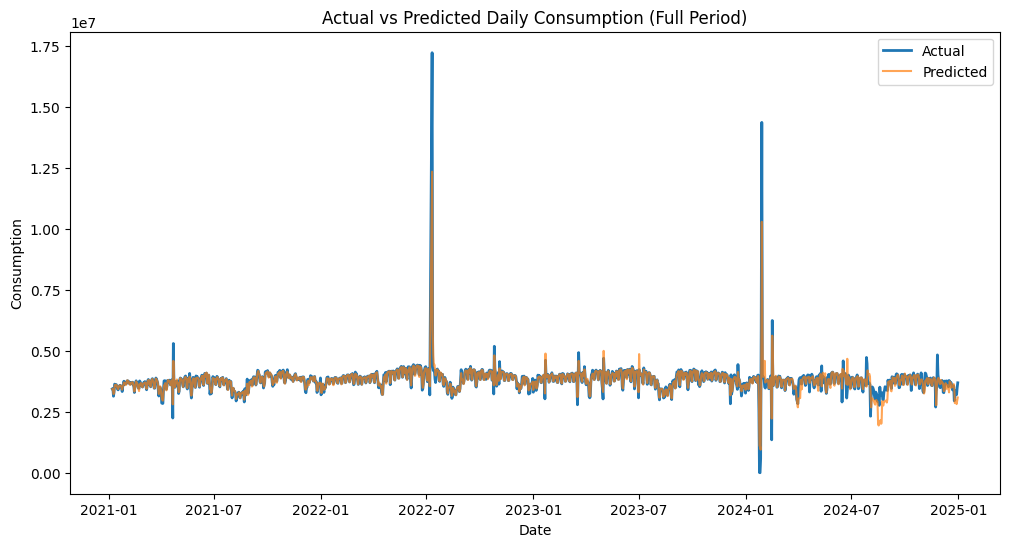

In [6]:
df["Predicted"] = model.predict(X)

plt.figure(figsize=(12,6))
plt.plot(df["FECHA"], df["CONSUM_DIARI"], label="Actual", linewidth=2)
plt.plot(df["FECHA"], df["Predicted"], label="Predicted", alpha=0.7)
plt.title("Actual vs Predicted Daily Consumption (Full Period)")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.legend()
plt.show()


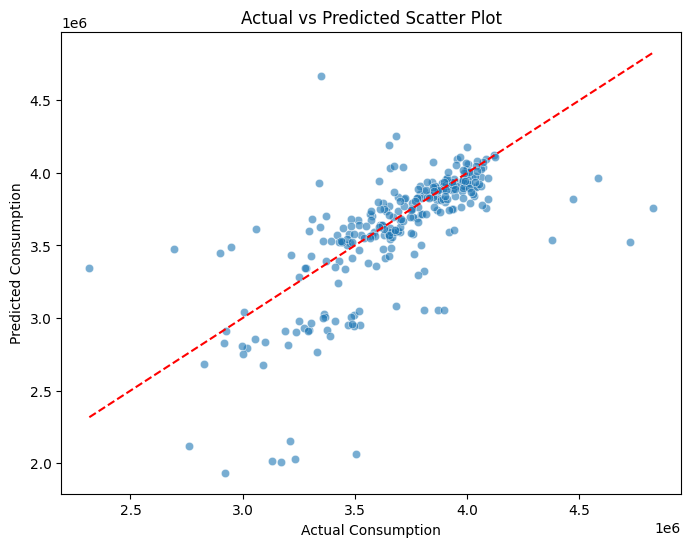

In [7]:
confuding_matrix = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

plt.figure(figsize=(8,6))
sns.scatterplot(data=confuding_matrix, x='Actual', y='Predicted', alpha=0.6)
plt.plot([confuding_matrix['Actual'].min(), confuding_matrix['Actual'].max()],
         [confuding_matrix['Actual'].min(), confuding_matrix['Actual'].max()],
         color='red', linestyle='--')
plt.title("Actual vs Predicted Scatter Plot")
plt.xlabel("Actual Consumption")
plt.ylabel("Predicted Consumption")
plt.show()